## Project 2 - Stock Price Prediction
### Mengfei Hu & Yuzhe Liu

## 1 Introduction
### 1.1 Problem Domain

We believe the historical financial behaviour of the stocks will provide some insightful information on its next-day prediction. That is also what makes financial institutions and some investors believe the meaningfulness of their work.

Hence, the goal of our project is to use different combination of available features and various models to predict future stock price to evaluate which model can achieve the best prediction performance. The metric for the prediction performance is the mean square error between predicted value and true value. In addition, we want to justify that P(T,E+^E)>T(T,E)) (where P is performance, T is task and E is experience) by modelling different companies with corresponding different amount of available data and comparing their prediction performance.

In [5]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM #Long short-time model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model #Linear regression model
from IPython.display import Image

### 1.2 Datasets

The Dataset used for this project is time-series data (from 2010 to 2016) for open and close stock price, lowest and highest stock price, and volumes that was sold on each day of various companies. Below are the label explanation for each column in the dataset.

-----------------

date: date for stock price

symbol: abbreviation for company name

open: open stock price of that day

close: close stock price of that day

high: highest stock price of that day

low: lowest stock price of that day

volume: volume of stock that was sold.

-----------------

The amount of available stock price varies with company. In this project, LyondellBasell, facebook and Microsoft are selected for investigation on how the amount of training data influence the prediction performance.

In [6]:
price = pd.read_csv('prices.csv')
price.head()

FileNotFoundError: File b'prices.csv' does not exist

In [7]:
# we are not interested in the date,
# given that each observation is separated by almost the same interval (per day).

# Three companies with diffrent size
company = price[price['symbol']=='MSFT']
#company = price[price['symbol']=='LYB']
#company = price[price['symbol']=='FB']

companyStock = company.close.values.astype('float32')
companyStock = companyStock.reshape(len(companyStock), 1)
companyStock.shape

NameError: name 'price' is not defined

In [8]:
plt.plot(companyStock)
plt.title('all available stock price for Microsoft')
plt.xticks(())
plt.show()

NameError: name 'companyStock' is not defined

In [5]:
# split into 70% train and 30% test sets
train_size = int(len(companyStock) * 0.7)
test_size = len(companyStock) - train_size
train, test = companyStock[0:train_size,:], companyStock[train_size:len(companyStock),:]
train.shape, test.shape

((1233, 1), (529, 1))

## 2 Methods and Assumptions

The prediction of close stock price will be investigated in three aspects to evaluate P(T,E+^E)>T(T,E)), including time windows, models and number of features. Time window sizes of 1 day, 5 days and 10 days have been tried with both linear regression(LR) and Long Short-Time Memory (LSTM). Section 2.1 and section 2.2 use only close stock price as input for models.

### 2.1 Time window (look_back)

Time window size indicates the time span between the input close price used to predict the output close price. For example, to predict tomorrow's stock price, previous 5 days close price will be used if the time window is set to be 5.

In [6]:
# convert an array of values into a dataset matrix
# it creates a dataset where X is the number of passengers at a given time (t), 
# and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [7]:
# look_back is the setting for size of time window
# if look_back = 1, which means we are using nextday model
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape,trainY.shape,testX.shape,testY.shape

((1231, 1), (1231,), (527, 1), (527,))

### 2.2 Prediction Models (LR vs. LSTM)

The prediction of next-day close stock price has been simulated with Linear Regression and Long Short-Time Memory.  70% of the available data is used as train data while the rest 30% is test data.

----------------------

Linear Regression

The simplest form of equation is one independent variable defined as y = ax + b, when the time window size equals one. Window size determines the number of independent variables as inputs. 

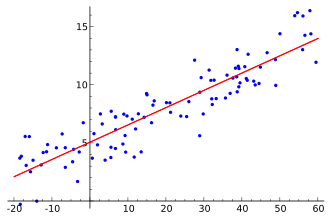

In [9]:
Image(filename='LinearRegression.png') 

Long Short-Time Memory 

LSTM is one kind of recurrent neural networks model, which is specially desinged to avoid the long-term dependency problem. Like all the other recurrent neural networks models, LSTM also has the form of a chain of repeating modules of neural network. However the difference is that LSTM can has different structure in each module.The core idea behind it is first determine what to throw away from cell state, then what to store and finally what to output. This algorithm works pretty well in many industrial problems.

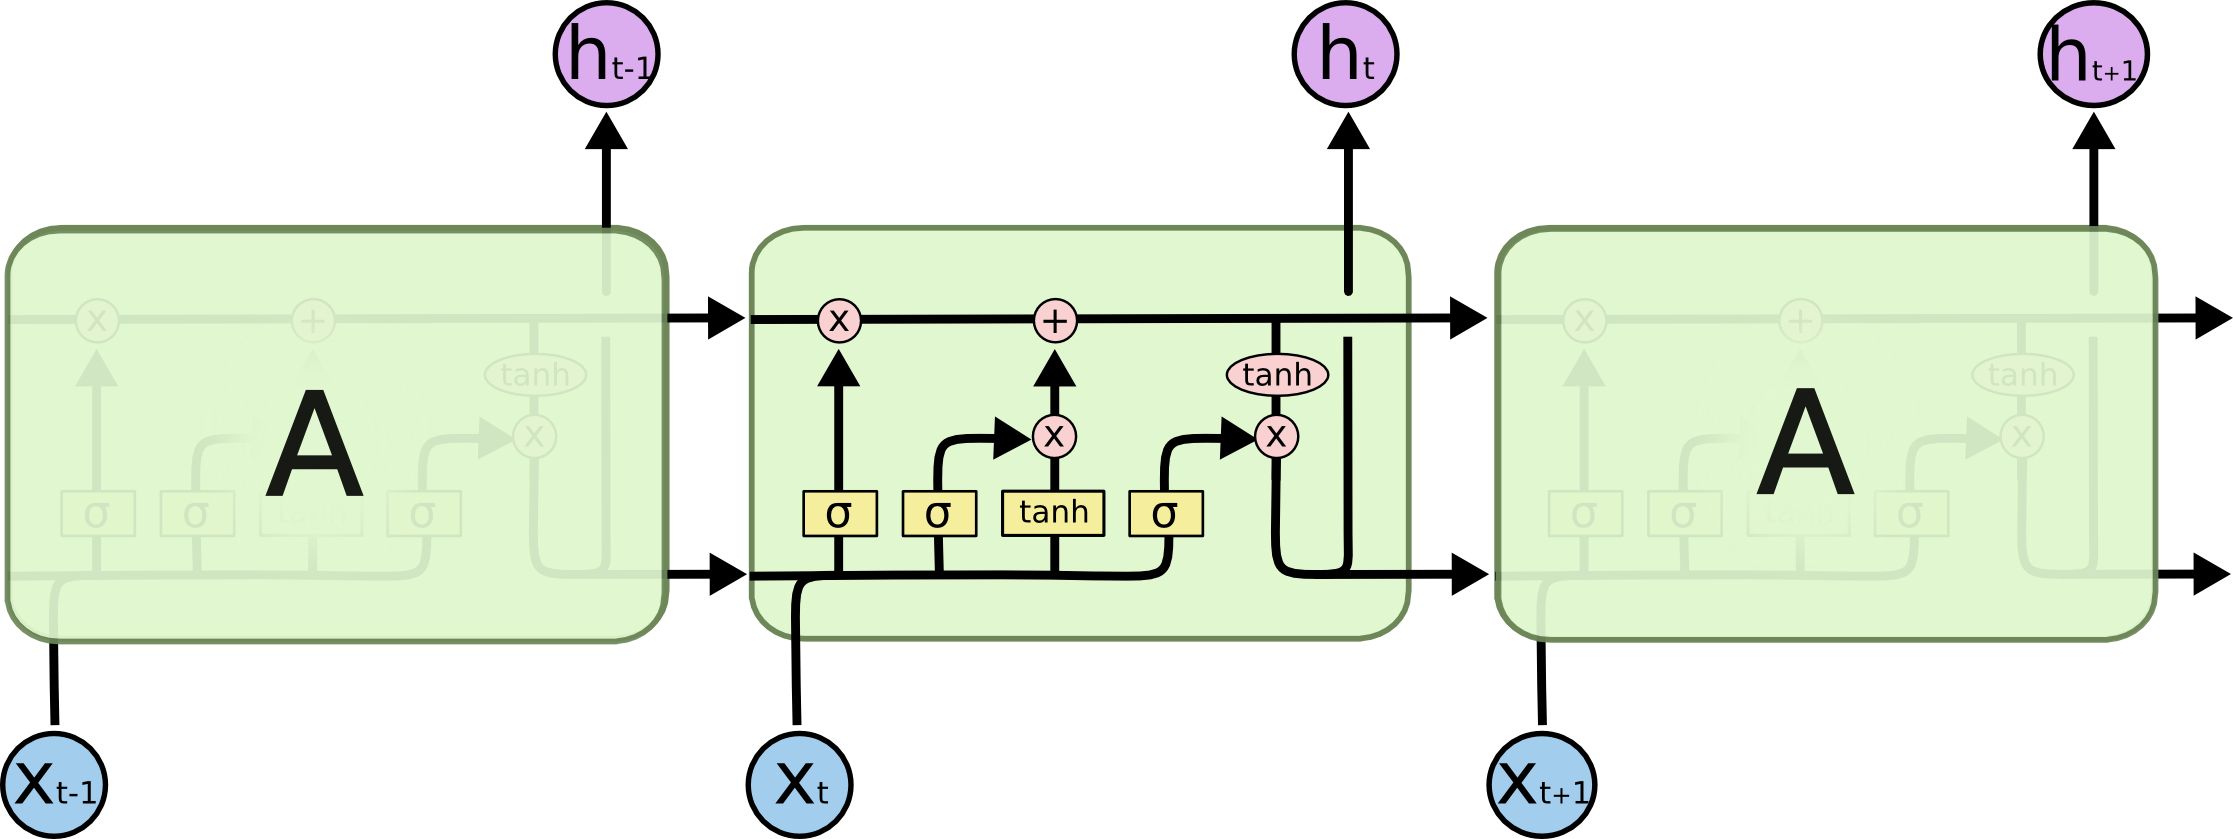

In [11]:
Image(filename='LSTM3-chain.png') 
# source: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

### 2.3 Features (Adding Open,Volume)

In the previous two section, there ins only one feature used for the models, which is the close price. Hence, we consider to use more features to do the prediction. The added features to predict next-day closing stock prices include the open price, close price and volume sold in previous day.

## 3 Prediction Approaches
Below is the implementation of the models and assumptions explained in section 2.
### 3.1 LR

In [8]:
# build the linear regression model
# train the model using the training sets
regr = linear_model.LinearRegression()
regr.fit(trainX, trainY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
# make predictions
testPredict = regr.predict(testX)
# The coefficients
print('Coefficients:',regr.coef_)
# The mean squared error
testMSE = mean_squared_error(testPredict, testY)
print("Prediction MSE: %.8f" % testMSE )

Coefficients: [ 1.00052845]
Prediction MSE: 0.62026410


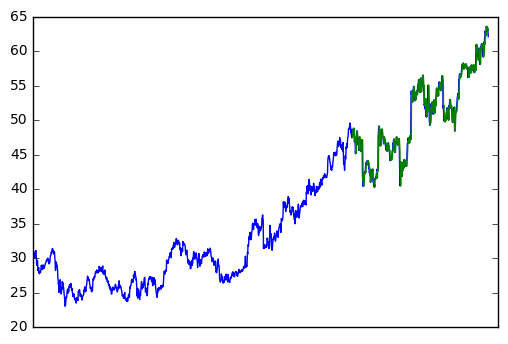

In [10]:
# shift test predictions for plotting
testPredict = testPredict.reshape(len(testPredict),1)
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(companyStock)-len(testPredict):len(companyStock),:] = testPredict

# plot baseline and predictions
plt.plot(companyStock)
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

In [11]:
# rerun the model with time window of 5 days / 10 days
look_back = 5
#look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
regr = linear_model.LinearRegression()
regr.fit(trainX, trainY)

testPredict = regr.predict(testX)
print('Coefficients:',regr.coef_)
testMSE = mean_squared_error(testPredict, testY)
print("Prediction MSE: %.8f" % testMSE )

Coefficients: [ 0.03955124 -0.01977211 -0.02842844  0.00667846  1.0027982 ]
Prediction MSE: 0.62291668


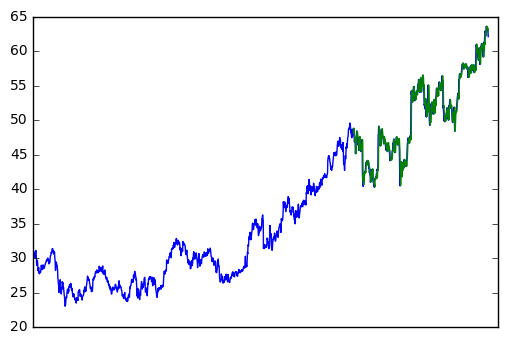

In [12]:
testPredict = testPredict.reshape(len(testPredict),1)
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(companyStock)-len(testPredict):len(companyStock),:] = testPredict

# plot baseline and predictions
plt.plot(companyStock)
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

### 3.2 LSTM

In [13]:
# rescale the data to the range of 0-to-1 (normalizing data)
scaler = MinMaxScaler(feature_range=(0, 1))
companyStock = scaler.fit_transform(companyStock)
companyStock

array([[ 0.19551837],
       [ 0.19576454],
       [ 0.19108593],
       ..., 
       [ 0.98448664],
       [ 0.98227042],
       [ 0.96355575]], dtype=float32)

In [14]:
# split into 70% train and 30% test sets
train_size = int(len(companyStock) * 0.7)
test_size = len(companyStock) - train_size
train, test = companyStock[0:train_size,:], companyStock[train_size:len(companyStock),:]
train.shape, test.shape

((1233, 1), (529, 1))

In [15]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape,trainY.shape,testX.shape,testY.shape

((1231, 1), (1231,), (527, 1), (527,))

In [16]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape,trainY.shape,testX.shape,testY.shape

((1231, 1, 1), (1231,), (527, 1, 1), (527,))

In [17]:
# build the LSTM
lstm = Sequential()
lstm.add(LSTM(4, input_shape=(1, look_back)))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer='adam')

In [18]:
# train the model
lstm.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
5s - loss: 0.0158
Epoch 2/10
4s - loss: 0.0012
Epoch 3/10
3s - loss: 1.3589e-04
Epoch 4/10
3s - loss: 1.3392e-04
Epoch 5/10
3s - loss: 1.3234e-04
Epoch 6/10
3s - loss: 1.3171e-04
Epoch 7/10
4s - loss: 1.2945e-04
Epoch 8/10
3s - loss: 1.3224e-04
Epoch 9/10
3s - loss: 1.2893e-04
Epoch 10/10
3s - loss: 1.3310e-04


In [19]:
# make predictions
testPredict = lstm.predict(testX)

# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [20]:
testMSE = mean_squared_error(testPredict[:,0],testY[0])
print("Prediction MSE: %.8f" % testMSE )

Prediction MSE: 0.93961613


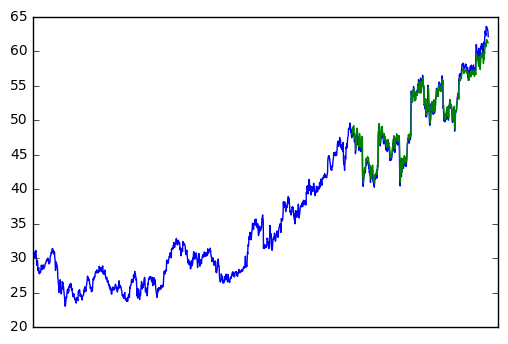

In [21]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainX)+(look_back*2)+1:len(companyStock)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(companyStock))
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

In [22]:
# rerun the model with time window of 5 days / 10 days
look_back = 5
#look_back = 10
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs = 10,batch_size=1, verbose=2)

Epoch 1/10
5s - loss: 0.0054
Epoch 2/10
4s - loss: 2.8162e-04
Epoch 3/10
4s - loss: 2.5944e-04
Epoch 4/10
4s - loss: 2.4513e-04
Epoch 5/10
3s - loss: 2.2849e-04
Epoch 6/10
3s - loss: 2.1630e-04
Epoch 7/10
4s - loss: 2.0874e-04
Epoch 8/10
4s - loss: 1.9640e-04
Epoch 9/10
4s - loss: 1.8789e-04
Epoch 10/10
4s - loss: 1.9169e-04


In [23]:
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [24]:
testMSE = mean_squared_error(testPredict[:,0],testY[0])
print("Prediction MSE: %.8f" % testMSE )

Prediction MSE: 1.95490095


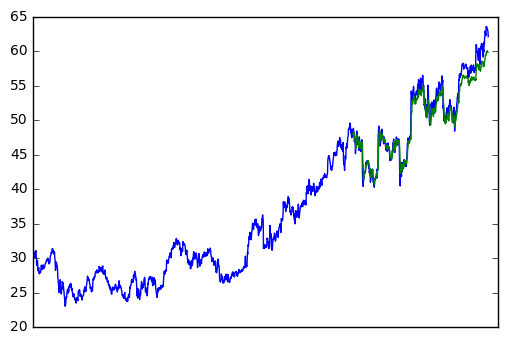

In [25]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainX)+(look_back*2)+1:len(companyStock)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(companyStock))
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

### 3.3 Adding features

In [26]:
openStock = company.open.values.astype('float32')
openStock = openStock.reshape(len(openStock), 1)
openStock

array([[ 30.62000084],
       [ 30.85000038],
       [ 30.87999916],
       ..., 
       [ 63.40000153],
       [ 62.86000061],
       [ 62.95999908]], dtype=float32)

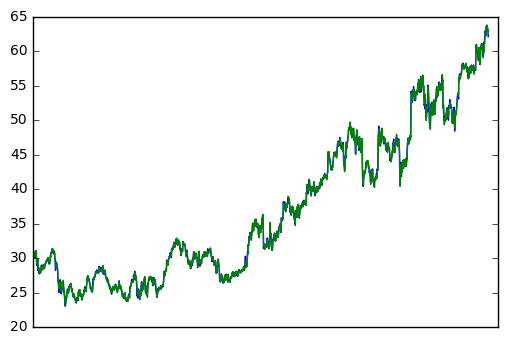

In [27]:
companyStock = scaler.inverse_transform(companyStock)
fig = plt.figure()
plt.plot(companyStock)
plt.plot(openStock)
plt.xticks(())
plt.show()

In [28]:
train_size = int(len(openStock) * 0.7)
test_size = len(openStock) - train_size

company.index = range(company.shape[0])
input1=pd.DataFrame(company.open[0:len(company.open)-1])
input2=pd.DataFrame(company.open[1:len(company.open)])
input3=pd.DataFrame(company.close[0:len(company.close)-1])
input4=pd.DataFrame(company.volume[0:len(company.close)-1])
input1.columns=['open1']
input2.columns=['open2']
input3.columns=['close1']
input4.columns=['volume1']
input2.index = range(input2.shape[0])
input_all = input1.join(input2)
input_all = input_all.join(input3).join(input4)
input_all.tail()

,open1,open2,close1,volume1
1756,63.840000,63.450001,63.549999,22176600
1757,63.450001,63.209999,63.240002,12403800
1758,63.209999,63.400002,63.279999,11763200
1759,63.400002,62.860001,62.990002,14653300
1760,62.860001,62.959999,62.900002,10250600


In [29]:
output_all = pd.DataFrame(company.close[1:len(company.close)])
output_all.index = range(output_all.shape[0])
output_all.tail()

,close
1756,63.240002
1757,63.279999
1758,62.990002
1759,62.900002
1760,62.139999


In [30]:
trainX, testX = input_all.ix[0:train_size,:], input_all.ix[train_size:len(openStock),:]
print(trainX.shape, testX.shape)
trainY, testY = output_all.ix[0:train_size,:], output_all.ix[train_size:len(openStock),:]
print(trainY.shape, testY.shape)
trainX = np.array(trainX)
testX = np.array(testX)
trainY = np.array(trainY)
testY = np.array(testY)

(1234, 4) (528, 4)
(1234, 1) (528, 1)


In [31]:
regr2 = linear_model.LinearRegression()
regr2.fit(trainX, trainY)
print('Coefficients:',regr2.coef_)
testMSE = mean_squared_error(regr2.predict(testX), testY)
print("Prediction MSE: %.8f" % testMSE )

Coefficients: [[ -2.07587312e-02   9.73854885e-01   4.59404276e-02  -1.24532962e-09]]
Prediction MSE: 0.32195103


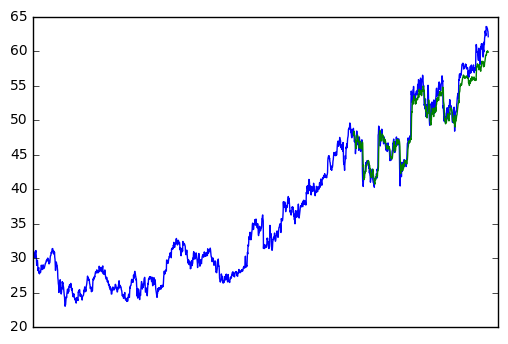

In [32]:
testPredict = testPredict.reshape(len(testPredict),1)
testPredictPlot = np.empty_like(companyStock)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(companyStock)-len(testPredict):len(companyStock),:] = testPredict

# plot baseline and predictions
plt.plot(companyStock)
plt.plot(testPredictPlot)
plt.xticks(())
plt.show()

## 4 Findings

Combined with Figures in previous sections, it can be seen from the table below:

1. P(T,E+^E)>T(T,E))
2. a small amount of data: LR better than LSTM
   a large amount of data: LSTM better than LR (potential)
3. Large window size of stock price prediction has poorer prediction performance than smaller window size.Looking back one day has the best prediciton performance.
4. With open price, close price and volumn of previous day as well as the open price of predicted day, it will be more accurate to predict the closing price of that day.


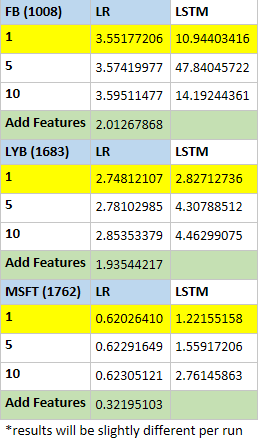

In [33]:
Image(filename='MSE.png') 

## 5 Limitation & Future Work

limitation:

1. The maximum amount of available of one company stock price is relatively small. There is no way to justify whether LSTM really performances better than LR when the dataset is very large.
2. The time series feature are also limited.
3. Though the predicted stock price is very close to the true value of stock price and the error is very small, it will be more useful to predict whether the stock price will increase or decrease by classification. Since Mean Square Error does not distinguish positive and negative difference and a small difference in stock price will lead to completely different financial result. 

---------------
Future work:

1. Various models can be utilized to predict the classification drop and rise of next-day's stock price. 
2. One case study can be make to simulate the accumulated effect of human' behaviour of purchasing stock, aiming to see whether different model will be beneficial for stock purchasing decision


## 6 Summary

The mean square error drops when more data is added to the model. Moreover, linear regression works better than Long Short-time Momery in the cases we simulated but LSTM has a potential to have better performance when the experience (E: avilable data) is larger since MSE of LSTM drop quicker than LR as the increase of E. However, we are not able to justify that due to the limited amount of available data for each company. When the window size of stock price prediction increases, the accuracy of the prediction reduces. That means it is more difficult to predict next-day stock price when look back too many days, which makes the model too complex and causing overfitting. With more features added, the stock price prediction drops a lot.

Though the accuracy of stock price prediction is high, it is not so useful for stock purchasing decision since the fluctuation of stock price of each day is small itself and it requires high sensitivity to make reasonable stock purchasing decision. More work can be focused on predicting the rise and fall of the future stock price.